## Running topic modeling

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import gensim

import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

/usr/local/lib/python3.6/dist-packages/requests/__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)
/usr/local/lib/python3.6/dist-packages/paramiko/transport.py:33: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography and will be removed in a future release.
  from cryptography.hazmat.backends import default_backend


In [2]:
# Turn string of text in list of words
def tokenize(docs, tokenizer):
    docs = [doc.lower() for doc in docs]
    docs = [tokenizer.tokenize(doc) for doc in docs]
    docs = [[d.strip() for d in doc if d.strip()] for doc in docs]
    docs = [' '.join(doc).split(' ') for doc in docs]
    
    return docs

# Remove stopwords define in nltk
def clen_words(docs, stopwords=set()):
    bag = [[word for word in doc if valid_word(word, stopwords)] for doc in docs]  
    
    return bag

# Define what is a valid word
def valid_word(word, stopwords):
    return (word not in stopwords and len(word) >= 3 and not word.isnumeric())

def lemmatize(docs, lemmatizer):
    return [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

In [3]:
# Import data and define initial documents
df = pd.read_csv('data/meta_review.csv', index_col=0)

# Fill empty Author Keywords values with empty string
df['author_keywords'] = df['author_keywords'].fillna('')

# Make Year and number of citations a integer
df['year'] = df['year'].astype('Int64')
df['number_citation'] = df['number_citation'].astype('Int64')

docs = df['title'] + ' ' + df['abstract'] + ' ' + df['author_keywords']

In [4]:
# Tokenize and clean documents
new_stopwords = ['research', 'review', 'literature', 'analysis']
stopwords = nltk.corpus.stopwords.words('english') + new_stopwords
tokenizer = nltk.tokenize.RegexpTokenizer(r'[\w|\-]+')
lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()

docs = tokenize(docs, tokenizer)
docs = clen_words(docs, stopwords)
docs = lemmatize(docs, lemmatizer)

In [5]:
# Add bigrams to documents
bigram = gensim.models.Phrases(docs, min_count=30)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            docs[idx].append(token)

In [6]:
# Parameters of the model
no_below=30; no_above=0.6; keep_n=5000; num_topics = 7; passes=10; iterations=5000; random_state=5
#no_below=30; no_above=0.6; keep_n=5000; num_topics = 7; passes=10; iterations=5000; random_state=43

# Create dictionary and corpus
dictionary = gensim.corpora.Dictionary(docs)
dictionary.filter_extremes(no_below=no_below, no_above=no_above, keep_n=keep_n)

corpus = [dictionary.doc2bow(doc) for doc in docs]

# Fit model
LDA_model = gensim.models.LdaModel(corpus, id2word=dictionary, passes=passes, chunksize=1000, iterations=iterations,
                                   num_topics=num_topics, eval_every=None, random_state=random_state)

# Print results
topics_matrix = LDA_model.show_topics(formatted=False, num_words=7)
for i in topics_matrix:
    print(f'Topic {i[0] + 1}: {[str(pair[0]) for pair in i[1]]}')
    
# Compute model coherence
coherecenmodel = gensim.models.coherencemodel.CoherenceModel(model=LDA_model, texts=docs, coherence='c_v')
print(f'Model coherece {coherecenmodel.get_coherence()}')

Topic 1: ['urban', 'community', 'disaster', 'risk', 'assessment', 'study', 'management']
Topic 2: ['study', 'intervention', 'systematic', 'health', 'result', 'outcome', 'included']
Topic 3: ['supply', 'chain', 'supply_chain', 'concept', 'disruption', 'study', 'paper']
Topic 4: ['change', 'system', 'climate', 'community', 'food', 'climate_change', 'sustainability']
Topic 5: ['system', 'power', 'energy', 'power_system', 'health', 'resiliency', 'network']
Topic 6: ['change', 'ecosystem', 'stress', 'climate', 'response', 'environmental', 'specie']
Topic 7: ['health', 'factor', 'mental', 'mental_health', 'child', 'family', 'study']
Model coherece 0.5226506866603059


In [7]:
# Visualize results
roots_data = pyLDAvis.gensim.prepare(LDA_model, corpus, dictionary)
pyLDAvis.display(roots_data)

## Selecting papers inside topic model


Summary of topics:  
Topic 1: Urban-community-disaster resilience  
Topic 2: Health and psychological resilience  
Topic 3: Supply-chain resilience  
Topic 4: Food resilience  
Topic 5: Energy resilience  
Topic 6: Ecological-environmental resilience  

In [8]:
# Based on the result of the topic modeling, fill topic for each paper
df['topic'] = 0
for idx in range(len(corpus)):
    topic_number = sorted(LDA_model[corpus[idx]], reverse=True, key=lambda element: element[1])[0][0] + 1
    df.loc[idx, 'topic'] = int(topic_number)
    
# Merge topic1 and topic2
topic1 = 2; topic2 = 7
df.loc[df['topic'] == topic2, 'topic'] = topic1
num_topics -= 1

df[['title', 'journal_name', 'topic']].assign(tokens=docs).head()

,title,journal_name,topic,tokens
index,,,,
0,Software approaches for resilience of high per...,Frontiers of Computer Science,5,"[software, approach, resilience, high, perform..."
1,The effectiveness of mind-body approaches for ...,Archives of Gerontology and Geriatrics,2,"[effectiveness, mind-body, approach, enhancing..."
2,Influence of spirituality on moral distress an...,Intensive and Critical Care Nursing,2,"[influence, spirituality, moral, distress, res..."
3,Regional seismic risk and resilience assessmen...,Reliability Engineering and System Safety,1,"[regional, seismic, risk, resilience, assessme..."
4,Identification of Resilience Dimensions in Cri...,Journal of Legal Affairs and Dispute Resolutio...,1,"[identification, resilience, dimension, critic..."


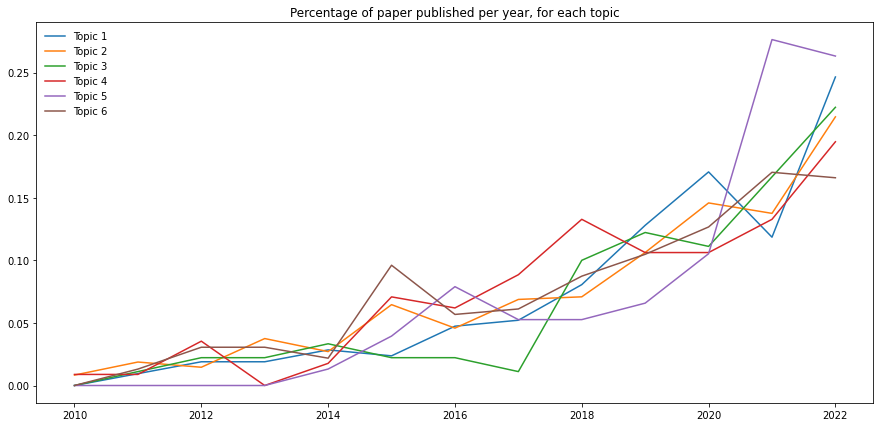

In [9]:
# Plot percentage of publication per year, inside topic
sns.set_context(rc = {'patch.linewidth': 0.0})
plt.figure(figsize=(15, 7))

years = np.arange(2010, 2023)
for topic in range(num_topics):
    dfTopic = df[df['topic'] == topic + 1]
    total_num_results = len(dfTopic)
    num_results = [(dfTopic['year'] == year).sum() / total_num_results for year in years] 
    sns.lineplot(x=years, y=num_results, label=f"Topic {topic + 1}") 

plt.title('Percentage of paper published per year, for each topic')
plt.legend()
plt.show()

In [10]:
# Print the three most common journal per topic
for topic in range(num_topics):
    dfTopic = df[df['topic'] == topic + 1]
    dfJournalCount = dfTopic['journal_name'].str.lower().value_counts().head(3)
    name_of_journals = list(dfJournalCount.index)
    number_of_occurences = list(dfJournalCount.values)
    
    print(f'Topic {topic + 1}, size {len(dfTopic)}')
    for idx in range(3): print(f'name: {name_of_journals[idx]}, occurences: {number_of_occurences[idx]}')
    print()

Topic 1, size 211
name: international journal of disaster risk reduction, occurences: 19
name: sustainability (switzerland), occurences: 18
name: sustainable cities and society, occurences: 8

Topic 2, size 480
name: frontiers in psychiatry, occurences: 11
name: clinical psychology review, occurences: 11
name: journal of child psychology and psychiatry and allied disciplines, occurences: 11

Topic 3, size 90
name: sustainability, occurences: 6
name: international journal of production research, occurences: 3
name: supply chain management, occurences: 3

Topic 4, size 113
name: sustainability (switzerland), occurences: 8
name: sustainability, occurences: 5
name: frontiers in sustainable food systems, occurences: 4

Topic 5, size 76
name: renewable and sustainable energy reviews, occurences: 11
name: international transactions on electrical energy systems, occurences: 4
name: energies, occurences: 4

Topic 6, size 229
name: frontiers in plant science, occurences: 6
name: theoretical and 

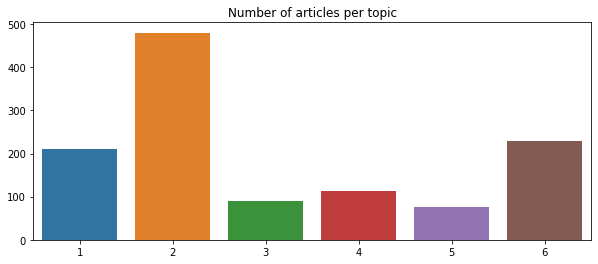

In [11]:
# Plot bar chart of the number of papers in each topic
plt.figure(figsize=(10, 4))

group_size = [len(group) for name, group in df.groupby('topic')]
topic = np.arange(0, num_topics) + 1
sns.barplot(x=topic, y=group_size)

plt.title('Number of articles per topic')
plt.show()

In [12]:
# Saving csv with most cited and newer papers per topic
dfReduced = df.drop(columns=['abstract', 'references'])

with pd.ExcelWriter("data/meta-review_topics.xlsx") as writer:
    for name, group in dfReduced.groupby('topic'):
        citation = group.sort_values(by=['number_citation'], ascending=False, na_position='last')
        citation.to_excel(writer, sheet_name=f'{name}_citation', index=False)
        
        newer = group.sort_values(by=['year'], ascending=False, na_position='last')
        newer.to_excel(writer, sheet_name=f'{name}_newer', index=False)